In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torchvision
import torch.optim as optim

import numpy as np
from sklearn.manifold import TSNE

import argparse, sys, os

import torch
from torchtext import data, datasets
import random
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
from collections import Counter
import matplotlib.pyplot as plt 


In [2]:
from google.colab import files
uploaded = files.upload()

In [3]:
import pandas as pd

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')


twitter = pd.read_csv("twitter.csv")
forum = pd.read_csv("Forum.csv")
wiki = pd.read_csv("Wiki.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# remove puctunations, https
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df

twitter = clean_text(twitter, 'text')
forum = clean_text(forum, 'text')
wiki = clean_text(wiki, 'text')

stopwords = nltk.corpus.stopwords.words('english')
twitter['text'] = twitter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
forum['text'] = forum['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
wiki['text'] = wiki['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))


In [5]:
twitter['domain'] = 0
forum['domain'] = 1
wiki['domain'] = 0

In [6]:
twitter = twitter[['text', 'label', 'domain']]
forum = forum[['text', 'label', 'domain']]
wiki = wiki[['text', 'label', 'domain']]

In [7]:
forum.to_csv('F.csv', index=False)
twitter.to_csv('T.csv', index=False)
wiki.to_csv('W.csv', index=False)

#tokenize

In [8]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
TEXT = data.Field(tokenize = 'spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)
DOMAIN = data.LabelField(dtype=torch.float)

In [10]:
#loading custom dataset
T =data.TabularDataset(path = 'T.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL),('domain',DOMAIN)],skip_header = True)

#print preprocessed text
print(vars(T.examples[0]))

{'text': ['paid', 'hold', 'monkey', 'look', 'monkey', 'real', 'af'], 'label': '0.0', 'domain': '0'}


In [11]:
#loading custom dataset
W =data.TabularDataset(path = 'W.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL),('domain',DOMAIN)],skip_header = True)

#print preprocessed text
print(vars(W.examples[0]))

{'text': ['right', 'fine', 'did', 'nt', 'even', 'start', 'discussion', 'joined', 'every', 'time', 'someone', 'tries', 'get', 'article', 'neutral', 'bullheaded', 'evolutionist', 'jumps', 'throat', 'stupid', 'evolution', 'proven', 'you', 're', 'idiot'], 'label': '1.0', 'domain': '0'}


In [12]:
#loading custom dataset
forum =data.TabularDataset(path = 'F.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL),('domain',DOMAIN)],skip_header = True)

#print preprocessed text
print(vars(forum.examples[0]))

{'text': ['watch', 'video', 'minutes', 'see', 'eventually', 'biracial', 'minority', 'butchered'], 'label': '1.0', 'domain': '1'}


split train, test, val

In [13]:
def split(train_size, dataset):
  train, test = dataset.split([6000, 2000], random_state = random.seed(SEED))
  train, other = train.split([train_size, 6000-train_size], random_state = random.seed(SEED))
  return train, test

train_size = 1000
T_train_data, T_test_data = split(train_size, T)
F_train_data, F_test_data = split(train_size, forum)
W_train_data, W_test_data = split(train_size, W)



#convert texts into integer sequences.

build vocabulary

In [14]:
#initialize glove embeddings
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(T_train_data, F_train_data, W_train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_) 
LABEL.build_vocab(T_train_data, F_train_data, W_train_data)
DOMAIN.build_vocab(T_train_data, F_train_data, W_train_data)

creat iterators

In [15]:
#set batch size
BATCH_SIZE = 64

#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#Load an iterator
T_train_iterator, T_test_iterator = data.BucketIterator.splits(
    (T_train_data,  T_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

F_train_iterator, F_test_iterator = data.BucketIterator.splits(
    (F_train_data, F_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

W_train_iterator, W_test_iterator = data.BucketIterator.splits(
    (W_train_data, W_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [16]:
print(len(T_train_iterator))
print(len(T_test_iterator))

16
32


In [17]:
print(len(T_train_data))
print(len(T_test_data))

1000
2000


In [18]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

class Extractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx, pretrained_embeddings):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes, embedding_dim))
        
        
        
        self.fc = nn.Linear(n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        # self.relu = nn.ReLU(inplace=True)
        # self.max_pool1d = nn.MaxPool1d(2,2)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        x = self.dropout(pooled_0)
        #x = [batch size, n_filters * len(filter_sizes)]
            
        return x

class Class_classifier(nn.Module):

    def __init__(self, n_filters, output_dim):
        super(Class_classifier, self).__init__()
        self.fc = nn.Linear(n_filters, output_dim)

    def forward(self, input):
        x = self.fc(input)
        return x

class Domain_classifier(nn.Module):

    def __init__(self, n_filters, output_dim):
        super(Domain_classifier, self).__init__()
        self.fc = nn.Linear(n_filters, output_dim)

    def forward(self, input, constant):
        input = GradReverse.grad_reverse(input, constant)
        return self.fc(input)




In [19]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [20]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = 1
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
pretrained_embeddings = TEXT.vocab.vectors

extractor = Extractor(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX,pretrained_embeddings )
class_classifier = Class_classifier(N_FILTERS, OUTPUT_DIM)
domain_classifier = Domain_classifier(N_FILTERS, OUTPUT_DIM)

check the number of parameters

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(extractor) + count_parameters(class_classifier) + count_parameters(domain_classifier):,} trainable parameters')

The model has 1,201,403 trainable parameters


zero the initial weights of the unknown and padding tokens







In [22]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

extractor.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
extractor.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [23]:
criterion = nn.BCEWithLogitsLoss()

extractor = extractor.to(device)
class_classifier = class_classifier.to(device)
domain_classifier = domain_classifier.to(device)

criterion = criterion.to(device)

define function to calculate the correct predictions

In [24]:
def train(training_mode, extractor, class_classifier, domain_classifier, criterion,
          source_data1, source_data2, target_data, optimizer, epoch):
  
    epoch_loss = 0
    epoch_acc = 0

    # setup models
    extractor.train()
    class_classifier.train()
    domain_classifier.train()

    # steps
    start_steps = epoch * len(source_data1)
    total_steps = 10 * len(source_data1)

    for batch_idx,(sdata1, sdata2, tdata) in enumerate(zip(source_data1, source_data2, target_data)):
        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-gamma * p)) - 1

            # prepare the data
            input1, label1, domain1 = sdata1.text, sdata1.label, sdata1.domain
            input2, label2, domain2 = sdata2.text, sdata2.label, sdata2.domain
            input3, label3, domain3 = tdata.text, tdata.label, tdata.domain
    
            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            # compute the output of source domain and target domain
            src_feature1 = extractor(input1)
            src_feature2 = extractor(input2)
            tgt_feature = extractor(input3)

            # compute the class loss of src_feature
            class_pred1 = class_classifier(src_feature1).squeeze(1)
            class_pred2 = class_classifier(src_feature2).squeeze(1)
            
            class_loss1 = criterion(class_pred1, label1)
            class_loss2 = criterion(class_pred2, label2)

            # compute the domain loss of src_feature and target_feature
            tgt_preds = domain_classifier(tgt_feature, constant).squeeze(1)
            src_pred1 = domain_classifier(src_feature1, constant).squeeze(1)
            src_pred2 = domain_classifier(src_feature2, constant).squeeze(1)
            
            tgt_loss = criterion(tgt_preds, domain3)
            src_loss1 = criterion(src_pred1, domain1)
            src_loss2 = criterion(src_pred2, domain2)
            
            domain_loss = tgt_loss + src_loss1 + src_loss2
            class_loss = class_loss1 + class_loss2

            loss = class_loss + theta * domain_loss

            loss.backward()
            optimizer.step()

            # print loss
            
            if (batch_idx + 1) % 10 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(input2), len(F_train_data),
                    100. * batch_idx / len(source_data2), loss.item(), class_loss.item(),
                    domain_loss.item()
                ))
                
            total_loss.append(loss.item())
            c_loss.append( class_loss.item())
            d_loss.append(domain_loss.item())
   

In [25]:
def test(extractor, class_classifier, domain_classifier, source_data1, source_data2, target_data):
 
    # setup the network
    extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    source_correct1 = 0.0
    source_correct2 = 0.0
    target_correct = 0.0
    domain_correct = 0.0
    tgt_correct = 0.0
    src_correct1 = 0.0
    src_correct2 = 0.0

    for batch_idx, sdata in enumerate(source_data1):
        # setup hyperparameters
        p = float(batch_idx) / len(source_data1)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1, domain1 = sdata.text, sdata.label, sdata.domain
        
        output1 = class_classifier(extractor(input1)).squeeze(1)
        output1 = torch.round(torch.sigmoid(output1))
        source_correct1 += (output1 == label1).cpu().sum()

        src_preds = domain_classifier(extractor(input1), constant).squeeze(1)
        src_preds = torch.round(torch.sigmoid(src_preds))
        src_correct1 += (src_preds == domain1).cpu().sum()

    for batch_idx, sdata in enumerate(source_data2):
        # setup hyperparameters
        p = float(batch_idx) / len(source_data2)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input2, label2, domain2 = sdata.text, sdata.label, sdata.domain
       
        output2 = class_classifier(extractor(input2)).squeeze(1)
        output2 = torch.round(torch.sigmoid(output2))
        source_correct2 += (output2 == label2).cpu().sum()

        src_preds = domain_classifier(extractor(input2), constant).squeeze(1)
        src_preds = torch.round(torch.sigmoid(src_preds))
        src_correct2 += (src_preds == domain2).cpu().sum()

    for batch_idx, tdata in enumerate(target_data):
        # setup hyperparameters
        p = float(batch_idx) / len(target_data)
        constant = 2. / (1. + np.exp(-10 * p)) - 1

        input3, label3, domain3 = tdata.text, tdata.label, tdata.domain
        
        output3 = class_classifier(extractor(input3)).squeeze(1)
        output3 = torch.round(torch.sigmoid(output3))
        target_correct += (output3 == label3).cpu().sum()

        src_preds = domain_classifier(extractor(input3), constant).squeeze(1)
        src_preds = torch.round(torch.sigmoid(src_preds))
        tgt_correct += (src_preds == domain3).cpu().sum()


    domain_correct = tgt_correct + src_correct1 + src_correct2

    print('\nSource1 Accuracy(classification): {}/{} ({:.4f}%)\nSource2 Accuracy(classification): {}/{} ({:.4f}%)\nTarget Accuracy(classification): {}/{} ({:.4f}%)\n'
          'Domain Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_correct1, len(T_test_data), 100. * float(source_correct1) / len(T_test_data),
        source_correct2, len(F_test_data), 100. * float(source_correct2) / len(F_test_data),
        target_correct, len(W_test_data), 100. * float(target_correct) / len(W_test_data),
        domain_correct, len(T_test_data) + len(F_test_data) + len(W_test_data),
        100. * float(domain_correct) / (len(T_test_data) + len(F_test_data) 
                                        + len(W_test_data))
    ))
    acc_list1.append(100. * float(source_correct1) / len(T_test_data))
    acc_list2.append(100. * float(source_correct2) / len(F_test_data))
    acc_list3.append(100. * float(target_correct) / len(W_test_data))
    acc_list4.append(100. * float(domain_correct) / (len(T_test_data) + len(F_test_data) 
                                        + len(W_test_data)))


In [26]:
def main():

    # prepare the source data and target data
    src_train_data1 = T_train_iterator
    src_test_data1 = T_test_iterator
    src_train_data2 = W_train_iterator
    src_test_data2 = W_test_iterator
    
    tgt_train_data = F_train_iterator
    tgt_test_data = F_test_iterator

    optimizer = optim.SGD([
            {'params': extractor.parameters()},
                            {'params': class_classifier.parameters()},
                            {'params': domain_classifier.parameters()}
    ], lr= 0.01, momentum= 0.9)


    for epoch in range(100):
    
        print('Epoch: {}'.format(epoch))
        train('dann', extractor, class_classifier, domain_classifier, criterion,
                    src_train_data1, src_train_data2, tgt_train_data, optimizer, epoch)
        test(extractor, class_classifier, domain_classifier, src_test_data1, src_test_data2, tgt_test_data)
        
total_loss, d_loss, c_loss = [],[],[]
acc_list1, acc_list2, acc_list3, acc_list4 = [],[],[],[]
if __name__ == '__main__':
    gamma = 10
    theta = 1
    time_start=time.time()
    main()
    time_end=time.time()
    print('total run time: (min)',(time_end-time_start)/60.)

Epoch: 0
[576/1000 (56%)]	Loss: 3.702778	Class Loss: 1.413746	Domain Loss: 2.289032

Source1 Accuracy(classification): 1163.0/2000 (58.1500%)
Source2 Accuracy(classification): 1076.0/2000 (53.8000%)
Target Accuracy(classification): 946.0/2000 (47.3000%)
Domain Accuracy: 4019.0/6000 (66.9833%)

Epoch: 1
[576/1000 (56%)]	Loss: 3.179984	Class Loss: 1.253878	Domain Loss: 1.926106

Source1 Accuracy(classification): 1580.0/2000 (79.0000%)
Source2 Accuracy(classification): 1340.0/2000 (67.0000%)
Target Accuracy(classification): 970.0/2000 (48.5000%)
Domain Accuracy: 4016.0/6000 (66.9333%)

Epoch: 2
[576/1000 (56%)]	Loss: 3.029416	Class Loss: 1.272081	Domain Loss: 1.757335

Source1 Accuracy(classification): 1616.0/2000 (80.8000%)
Source2 Accuracy(classification): 1595.0/2000 (79.7500%)
Target Accuracy(classification): 1087.0/2000 (54.3500%)
Domain Accuracy: 4028.0/6000 (67.1333%)

Epoch: 3
[576/1000 (56%)]	Loss: 3.108212	Class Loss: 1.288454	Domain Loss: 1.819759

Source1 Accuracy(classificati

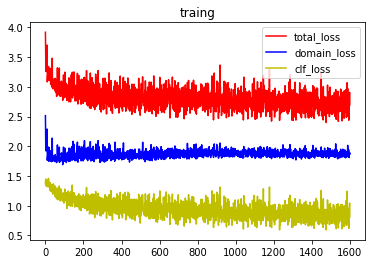

In [27]:
plt.plot(range(len(total_loss)),total_loss,c='r',label='total_loss')
plt.plot(d_loss,c='b',label='domain_loss')
plt.plot(c_loss,c='y',label='clf_loss')
plt.title('traing')
plt.legend(loc='best')
plt.show()

max target accuracy:  67.65


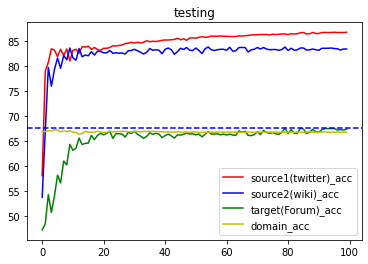

In [28]:
print('max target accuracy: ',max(acc_list3))
plt.plot(range(len(acc_list1)),acc_list1,c='r',label='source1(twitter)_acc')
plt.plot(acc_list2,c='b',label='source2(wiki)_acc')
plt.plot(acc_list3,c='g',label='target(Forum)_acc')
plt.plot(acc_list4,c='y',label='domain_acc')
plt.axhline(max(acc_list3),c='b',linestyle='--')
plt.title('testing')
plt.legend(loc='best')
plt.show()

[200, 400, 600, 800, 1000] [52.3, 61.65, 68.85, 69.7, 67.65]